In [70]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import os
import re
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

In [71]:
Data = np.loadtxt('Data.txt')

In [72]:
X = Data[:,:-1]
X.shape

(36308, 12)

In [73]:
Y = Data[:,-1]
Y.shape

(36308,)

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=9, stratify=Y)

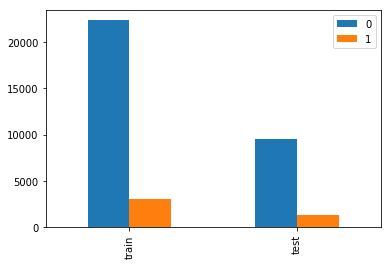

In [75]:
train_1 = (Y_train == 1).sum()
train_0 = (Y_train == 0).sum()
test_1 = (Y_test == 1).sum()
test_0 = (Y_test == 0).sum()
c = pd.DataFrame({'0':[train_0,test_0],'1':[train_1,test_1]},index = ['train', 'test'])
c.plot(kind = 'bar')
plt.show()

In [76]:
import copy
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

class Unbalance_estimator(object):
    
    def __init__(self, base_estimator, scoring):
        self.base_estimator = base_estimator
        self.estimators = []
        self.scoring = scoring
        
    def fit(self,X,y):
        Data = self.split(X,y)
        self.estimators = []
        for i in range(len(Data)):
            clf = copy.deepcopy(self.base_estimator)
            self.estimators.append(clf)
        for i,data in enumerate(Data):
            m = data.shape[0]
            permutation = list(np.random.permutation(m))
            data = data[permutation,:]
            self.estimators[i].fit(data[:,:-1], data[:,-1])
        return self
    
    def split(self,x_train, y_train):
        x_1 = x_train[y_train == 1]
        y_1 = y_train[y_train == 1]
        x_0 = x_train[y_train == 0]
        y_0 = y_train[y_train == 0]
        num_1 = x_1.shape[0]
        num_0 = x_0.shape[0]
        x_y_1 = np.concatenate((x_1,y_1.reshape(-1,1)),axis = 1)
        x_y_0 = np.concatenate((x_0,y_0.reshape(-1,1)),axis = 1)
        Data = []
        if num_1 > num_0:
            for i in range(10):
                c = np.random.rand(num_1)
                Data.append(np.concatenate((x_y_1[c < num_0/num_1], x_y_0), axis = 0))
        else:
            for i in range(10):
                c = np.random.rand(num_0)
                Data.append(np.concatenate((x_y_0[c < num_1/num_0], x_y_1), axis = 0)) 
        return Data

    def predict_proba(self, X):
        return np.stack([clf.predict_proba(X) for i,clf in enumerate(self.estimators)],axis = 2).mean(axis = 2)
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis = 1)
    
    def score(self, X, y):
        if self.scoring == 'accuracy':
            return accuracy_score(y, self.predict(X))
        if self.scoring == 'f1':
            return metrics.f1_score(y, self.predict(X)) 
        if self.scoring == 'auc':
            return roc_auc_score(y, self.predict_proba(X)[:,1])
    

In [77]:
from sklearn.model_selection import KFold
def my_cross_val_score(clf, x, y, cv = 5):
    kf = KFold(n_splits=cv)
    result = []
    for train_index, test_index in kf.split(x):
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]
        result.append(clf.fit(x_train,y_train).score(x_test,y_test))
    return np.array(result)

In [78]:
best_score = -1
best_C = -1
for C in [1, 10, 100, 1000]:
    clf = Unbalance_estimator(LogisticRegression(C = C, tol = 1e-5, solver= 'saga', max_iter = 3000), scoring = 'auc')
    score = my_cross_val_score(clf, X_train, Y_train, cv = 5).mean()
    if score > best_score:
        best_score = score
        best_C = C
clf = Unbalance_estimator(LogisticRegression(C = best_C, tol = 1e-5, solver= 'saga'), scoring = 'auc')
clf.fit(X_train, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [79]:
best_score

0.7985020474921602

In [80]:
best_C

100

In [81]:
clf.score(X_test,Y_test)

0.7975909695121519

In [82]:
joblib.dump(clf, 'LR1.pkl') 

['LR1.pkl']

In [83]:
clf = joblib.load( 'LR1.pkl')

In [84]:
clf.estimators[0].classes_

array([0., 1.])

In [85]:
from sklearn.metrics import confusion_matrix

In [86]:
confusion_matrix(Y_train, clf.predict(X_train))

array([[16637,  5692],
       [ 1007,  2079]], dtype=int64)

In [87]:
confusion_matrix(Y_test, clf.predict(X_test))

array([[7088, 2482],
       [ 423,  900]], dtype=int64)

In [88]:
from sklearn.metrics import classification_report

In [89]:
print(classification_report(Y_train, clf.predict(X_train)))

             precision    recall  f1-score   support

        0.0       0.94      0.75      0.83     22329
        1.0       0.27      0.67      0.38      3086

avg / total       0.86      0.74      0.78     25415



In [90]:
print(classification_report(Y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.94      0.74      0.83      9570
        1.0       0.27      0.68      0.38      1323

avg / total       0.86      0.73      0.78     10893



In [91]:
from sklearn.metrics import roc_auc_score

In [92]:
roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1],average = 'micro')

0.799643975280759

In [93]:
roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1],average = 'micro')

0.7975909695121519